# 🎯 Phase 4: Customer Segmentation

---

## Objectives

1. ✅ Determine optimal number of clusters (Elbow Method + Silhouette Score)
2. ✅ Perform K-Means clustering to segment customers
3. ✅ Profile each segment (size, churn rate, demographics, behavior)
4. ✅ Visualize segments (PCA 2D plot)
5. ✅ Provide business insights and retention strategies per segment
6. ✅ Add cluster labels as feature for Phase 5 modeling

---

**Part of:** Churn Prediction & Customer Analytics (Phase 4)

**Prerequisites:** Phase 3C (Model Preparation) - Requires train/test datasets

**Next:** Phase 5 - Churn Prediction Modeling (with segment features)

---

## 1. Environment Setup

In [1]:
# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Clustering
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples

# Utilities
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configuration
np.random.seed(42)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)

# Visualization styling
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

print("✅ Environment configured successfully!")

✅ Environment configured successfully!


## 2. Load Data from Phase 3C

In [2]:
# Define paths
project_root = Path('/Users/mihiniboteju/churn-prediction-project')
processed_path = project_root / 'data' / 'processed'
viz_path = project_root / 'visualizations' / 'figures'

# Load Phase 3C datasets
X_train = pd.read_csv(processed_path / 'X_train.csv')
X_test = pd.read_csv(processed_path / 'X_test.csv')
y_train = pd.read_csv(processed_path / 'y_train.csv').squeeze()
y_test = pd.read_csv(processed_path / 'y_test.csv').squeeze()

print("📊 DATA LOADED FROM PHASE 3C")
print("="*80)
print(f"\n✅ Training set: X_train {X_train.shape}, y_train {y_train.shape}")
print(f"✅ Test set: X_test {X_test.shape}, y_test {y_test.shape}")
print(f"✅ Total customers: {X_train.shape[0] + X_test.shape[0]:,}")
print(f"✅ Features: {X_train.shape[1]}")
print(f"\n💡 Note: We'll combine train+test for segmentation, then split again")

📊 DATA LOADED FROM PHASE 3C

✅ Training set: X_train (5634, 65), y_train (5634,)
✅ Test set: X_test (1409, 65), y_test (1409,)
✅ Total customers: 7,043
✅ Features: 65

💡 Note: We'll combine train+test for segmentation, then split again


## 3. Combine Data for Segmentation

**Why combine train+test?**
- Segmentation is unsupervised (doesn't use Churn labels)
- We want consistent segments across all customers
- After segmentation, we'll split back to train/test with cluster labels

In [3]:
print("🔧 Combining train and test sets for clustering...\n")

# Combine features and target
X_all = pd.concat([X_train, X_test], axis=0, ignore_index=True)
y_all = pd.concat([y_train, y_test], axis=0, ignore_index=True)

# Store original indices to split back later
train_size = len(X_train)
test_size = len(X_test)

print("✅ COMBINED DATASET FOR SEGMENTATION")
print("="*80)
print(f"\n✅ X_all: {X_all.shape}")
print(f"✅ y_all: {y_all.shape}")
print(f"✅ Total customers: {len(X_all):,}")
print(f"\n📝 Remember: First {train_size:,} = train, Last {test_size:,} = test")

🔧 Combining train and test sets for clustering...

✅ COMBINED DATASET FOR SEGMENTATION

✅ X_all: (7043, 65)
✅ y_all: (7043,)
✅ Total customers: 7,043

📝 Remember: First 5,634 = train, Last 1,409 = test


## 4. Determine Optimal Number of Clusters (K)

We'll use two methods:
- **Elbow Method**: Plot inertia (SSE) - look for "elbow" where decrease slows
- **Silhouette Score**: Measures cluster quality (0 to 1, higher is better)

In [4]:
print("🔍 FINDING OPTIMAL K (Number of Clusters)")
print("="*80)
print("\nTesting K = 2 to 10...\n")

# Test range of K values
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    # Train K-Means
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_all)
    
    # Calculate metrics
    inertia = kmeans.inertia_
    silhouette = silhouette_score(X_all, cluster_labels)
    
    inertias.append(inertia)
    silhouette_scores.append(silhouette)
    
    print(f"K={k:2d} | Inertia: {inertia:12,.2f} | Silhouette: {silhouette:.4f}")

print("\n✅ Evaluation complete!")

🔍 FINDING OPTIMAL K (Number of Clusters)

Testing K = 2 to 10...

K= 2 | Inertia:   119,472.40 | Silhouette: 0.2662
K= 3 | Inertia:    97,765.65 | Silhouette: 0.2329
K= 4 | Inertia:    87,400.53 | Silhouette: 0.2102
K= 5 | Inertia:    79,835.93 | Silhouette: 0.2096
K= 6 | Inertia:    73,544.92 | Silhouette: 0.2005
K= 7 | Inertia:    70,005.95 | Silhouette: 0.1959
K= 8 | Inertia:    66,886.26 | Silhouette: 0.1876
K= 9 | Inertia:    64,543.53 | Silhouette: 0.1717
K=10 | Inertia:    63,212.39 | Silhouette: 0.1543

✅ Evaluation complete!


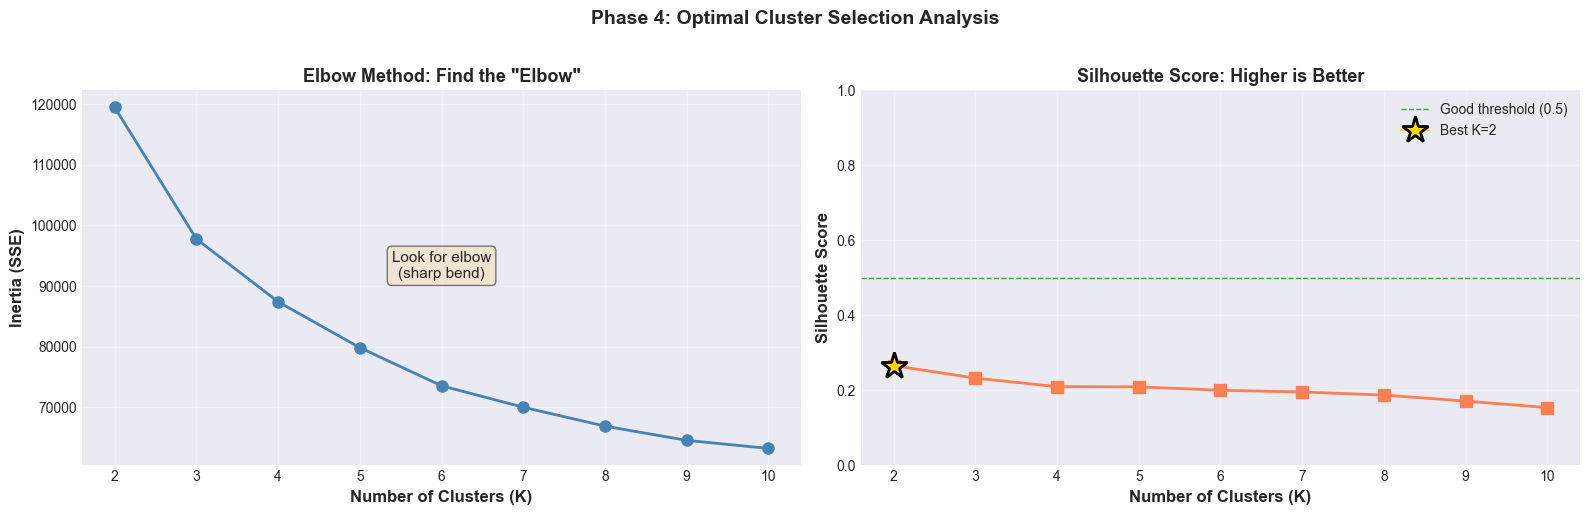


✅ Visualization saved: 22_optimal_k_analysis.png

💡 Recommended K: 2 (highest silhouette score: 0.2662)


In [7]:
# Visualize both metrics
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Elbow Method
axes[0].plot(k_range, inertias, marker='o', linewidth=2, markersize=8, color='steelblue')
axes[0].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Inertia (SSE)', fontsize=12, fontweight='bold')
axes[0].set_title('Elbow Method: Find the "Elbow"', fontsize=13, fontweight='bold')
axes[0].set_xticks(k_range)
axes[0].grid(alpha=0.3)
axes[0].annotate('Look for elbow\n(sharp bend)', xy=(0.5, 0.5), xycoords='axes fraction',
                 fontsize=11, ha='center', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Silhouette Score
axes[1].plot(k_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_xlabel('Number of Clusters (K)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Silhouette Score', fontsize=12, fontweight='bold')
axes[1].set_title('Silhouette Score: Higher is Better', fontsize=13, fontweight='bold')
axes[1].set_xticks(k_range)
axes[1].set_ylim(0, 1)
axes[1].grid(alpha=0.3)
axes[1].axhline(y=0.5, color='green', linestyle='--', linewidth=1, alpha=0.7, label='Good threshold (0.5)')
axes[1].legend()

# Highlight best K by silhouette
best_k = k_range[np.argmax(silhouette_scores)]
best_silhouette = max(silhouette_scores)
axes[1].plot(best_k, best_silhouette, marker='*', markersize=20, color='gold', 
             markeredgecolor='black', markeredgewidth=2, label=f'Best K={best_k}')
axes[1].legend()

plt.suptitle('Phase 4: Optimal Cluster Selection Analysis', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig(viz_path / '22_optimal_k_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: 22_optimal_k_analysis.png")
print(f"\n💡 Recommended K: {best_k} (highest silhouette score: {best_silhouette:.4f})")

## 5. Train K-Means with Optimal K

Based on the analysis above, we'll use the optimal K value.

In [9]:
# Select optimal K (you can change this based on visual inspection)
optimal_k = best_k  # From silhouette analysis, or manually set (e.g., optimal_k = 4)

print(f"🎯 TRAINING K-MEANS WITH K = {optimal_k}")
print("="*80)

# Train final K-Means model
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
cluster_labels = kmeans_final.fit_predict(X_all)

# Add cluster labels to dataframe
X_all_clustered = X_all.copy()
X_all_clustered['cluster_label'] = cluster_labels

print(f"\n✅ K-Means clustering complete!")
print(f"\n📊 Cluster Distribution:")
cluster_counts = pd.Series(cluster_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    percentage = count / len(cluster_labels) * 100
    print(f"   Cluster {cluster_id}: {count:5,} customers ({percentage:5.2f}%)")

# Check balance
max_cluster_pct = cluster_counts.max() / len(cluster_labels) * 100
min_cluster_pct = cluster_counts.min() / len(cluster_labels) * 100
print(f"\n💡 Balance: Largest {max_cluster_pct:.1f}% | Smallest {min_cluster_pct:.1f}%")
if max_cluster_pct / min_cluster_pct < 3:
    print("   ✅ Clusters are reasonably balanced")
else:
    print("   ⚠️  Some imbalance detected (acceptable for real data)")

🎯 TRAINING K-MEANS WITH K = 2

✅ K-Means clustering complete!

📊 Cluster Distribution:
   Cluster 0: 3,978 customers (56.48%)
   Cluster 1: 3,065 customers (43.52%)

💡 Balance: Largest 56.5% | Smallest 43.5%
   ✅ Clusters are reasonably balanced


## 6. Segment Profiling

Analyze each segment to understand who they are.

In [10]:
print("📊 PROFILING CUSTOMER SEGMENTS")
print("="*80)

# Add churn labels for profiling
X_all_clustered['Churn'] = y_all.values

# Create segment profile
segment_profiles = []

for cluster_id in range(optimal_k):
    cluster_data = X_all_clustered[X_all_clustered['cluster_label'] == cluster_id]
    
    profile = {
        'Cluster': cluster_id,
        'Size': len(cluster_data),
        'Percentage': len(cluster_data) / len(X_all_clustered) * 100,
        'Churn_Rate': cluster_data['Churn'].mean() * 100,
        'Avg_Tenure': cluster_data['tenure'].mean() if 'tenure' in cluster_data.columns else 0,
        'Avg_MonthlyCharges': cluster_data['MonthlyCharges'].mean() if 'MonthlyCharges' in cluster_data.columns else 0,
        'Avg_TotalCharges': cluster_data['TotalCharges'].mean() if 'TotalCharges' in cluster_data.columns else 0,
    }
    
    segment_profiles.append(profile)

# Create DataFrame
segments_df = pd.DataFrame(segment_profiles)
segments_df = segments_df.sort_values('Churn_Rate', ascending=False)

print("\nSEGMENT OVERVIEW (sorted by Churn Risk):\n")
print(segments_df.to_string(index=False))

print("\n" + "="*80)

📊 PROFILING CUSTOMER SEGMENTS

SEGMENT OVERVIEW (sorted by Churn Risk):

 Cluster  Size  Percentage  Churn_Rate  Avg_Tenure  Avg_MonthlyCharges  Avg_TotalCharges
       0  3978     56.4816     29.6883     -0.5144             -0.6241           -0.6964
       1  3065     43.5184     22.4470      0.6570              0.7971            0.8840



In [11]:
# Detailed profiling: Top features per segment
print("\n📋 DETAILED SEGMENT CHARACTERISTICS")
print("="*80)

# Load feature metadata to identify feature types
feature_metadata = pd.read_csv(processed_path / 'phase3c_final_features.csv')
numerical_features = feature_metadata[feature_metadata['Type'] == 'Numerical']['Feature'].tolist()

for cluster_id in range(optimal_k):
    cluster_data = X_all_clustered[X_all_clustered['cluster_label'] == cluster_id]
    churn_rate = cluster_data['Churn'].mean() * 100
    
    print(f"\n{'='*80}")
    print(f"CLUSTER {cluster_id} | Size: {len(cluster_data):,} ({len(cluster_data)/len(X_all_clustered)*100:.1f}%) | Churn Rate: {churn_rate:.1f}%")
    print(f"{'='*80}")
    
    # Key numerical features
    if 'tenure' in cluster_data.columns:
        print(f"   • Avg Tenure: {cluster_data['tenure'].mean():.1f} months")
    if 'MonthlyCharges' in cluster_data.columns:
        print(f"   • Avg Monthly Charges: ${cluster_data['MonthlyCharges'].mean():.2f}")
    if 'TotalCharges' in cluster_data.columns:
        print(f"   • Avg Total Charges: ${cluster_data['TotalCharges'].mean():.2f}")
    if 'total_services' in cluster_data.columns:
        print(f"   • Avg Services Used: {cluster_data['total_services'].mean():.1f}")
    
    # Top 3 distinguishing features (highest mean values for binary features)
    binary_features = [f for f in feature_metadata[feature_metadata['Type'] == 'Binary/Categorical']['Feature'].tolist() 
                       if f in cluster_data.columns]
    
    if binary_features:
        binary_means = cluster_data[binary_features].mean().sort_values(ascending=False).head(5)
        print(f"\n   Top Characteristics:")
        for feat, val in binary_means.items():
            if val > 0.5:  # Only show if majority have this feature
                print(f"      • {feat}: {val*100:.1f}%")

print("\n" + "="*80)


📋 DETAILED SEGMENT CHARACTERISTICS

CLUSTER 0 | Size: 3,978 (56.5%) | Churn Rate: 29.7%
   • Avg Tenure: -0.5 months
   • Avg Monthly Charges: $-0.62
   • Avg Total Charges: $-0.70
   • Avg Services Used: -0.7

   Top Characteristics:
      • PhoneService: 88.1%
      • has_internet: 61.6%
      • is_new_customer: 51.7%
      • PaperlessBilling: 51.2%
      • gender: 50.3%

CLUSTER 1 | Size: 3,065 (43.5%) | Churn Rate: 22.4%
   • Avg Tenure: 0.7 months
   • Avg Monthly Charges: $0.80
   • Avg Total Charges: $0.88
   • Avg Services Used: 0.9

   Top Characteristics:
      • has_internet: 100.0%
      • has_any_services: 99.6%
      • PhoneService: 93.2%
      • is_high_price: 84.8%
      • StreamingMovies_binary: 71.7%



## 7. Visualize Churn Rate by Segment

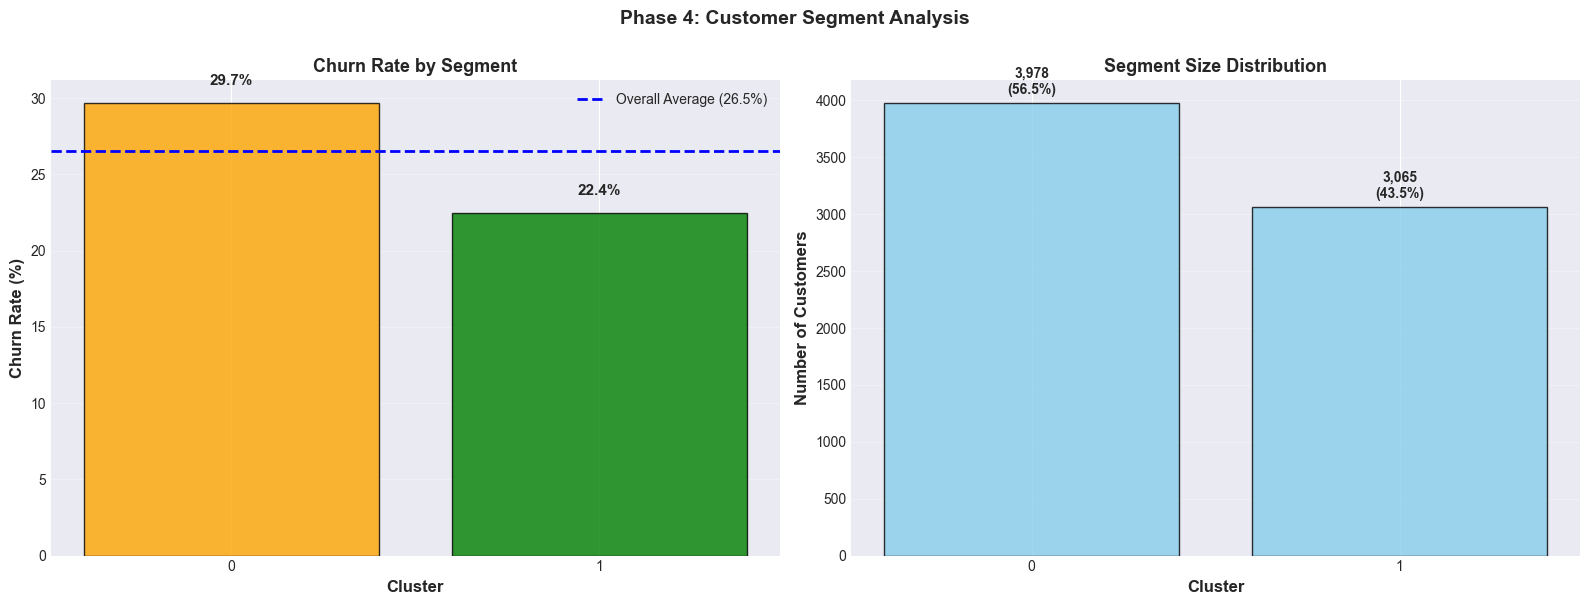

✅ Visualization saved: 23_segment_churn_analysis.png


In [12]:
# Churn rate comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Churn Rate by Segment
segments_sorted = segments_df.sort_values('Cluster')
colors = ['red' if cr > 40 else 'orange' if cr > 25 else 'green' for cr in segments_sorted['Churn_Rate']]

bars = axes[0].bar(segments_sorted['Cluster'], segments_sorted['Churn_Rate'], 
                    color=colors, edgecolor='black', alpha=0.8)
axes[0].axhline(y=y_all.mean()*100, color='blue', linestyle='--', linewidth=2, 
                label=f'Overall Average ({y_all.mean()*100:.1f}%)')
axes[0].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Churn Rate (%)', fontsize=12, fontweight='bold')
axes[0].set_title('Churn Rate by Segment', fontsize=13, fontweight='bold')
axes[0].set_xticks(segments_sorted['Cluster'])
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Add value labels
for bar, val in zip(bars, segments_sorted['Churn_Rate']):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 1,
                f'{val:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Plot 2: Segment Size
axes[1].bar(segments_sorted['Cluster'], segments_sorted['Size'], 
            color='skyblue', edgecolor='black', alpha=0.8)
axes[1].set_xlabel('Cluster', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Customers', fontsize=12, fontweight='bold')
axes[1].set_title('Segment Size Distribution', fontsize=13, fontweight='bold')
axes[1].set_xticks(segments_sorted['Cluster'])
axes[1].grid(axis='y', alpha=0.3)

# Add percentage labels
for i, (cluster, size, pct) in enumerate(zip(segments_sorted['Cluster'], 
                                               segments_sorted['Size'], 
                                               segments_sorted['Percentage'])):
    axes[1].text(i, size + 50, f'{size:,}\n({pct:.1f}%)', 
                ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.suptitle('Phase 4: Customer Segment Analysis', fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.savefig(viz_path / '23_segment_churn_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Visualization saved: 23_segment_churn_analysis.png")

## 8. Visualize Segments in 2D (PCA)

Use PCA to reduce 65 features to 2 dimensions for visualization.

In [13]:
print("🎨 Creating 2D visualization with PCA...\n")

# Apply PCA (reduce to 2 components)
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_all)

print(f"✅ PCA complete!")
print(f"   • Explained variance: {pca.explained_variance_ratio_.sum()*100:.2f}%")
print(f"   • PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"   • PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")

🎨 Creating 2D visualization with PCA...

✅ PCA complete!
   • Explained variance: 62.07%
   • PC1: 42.44%
   • PC2: 19.62%


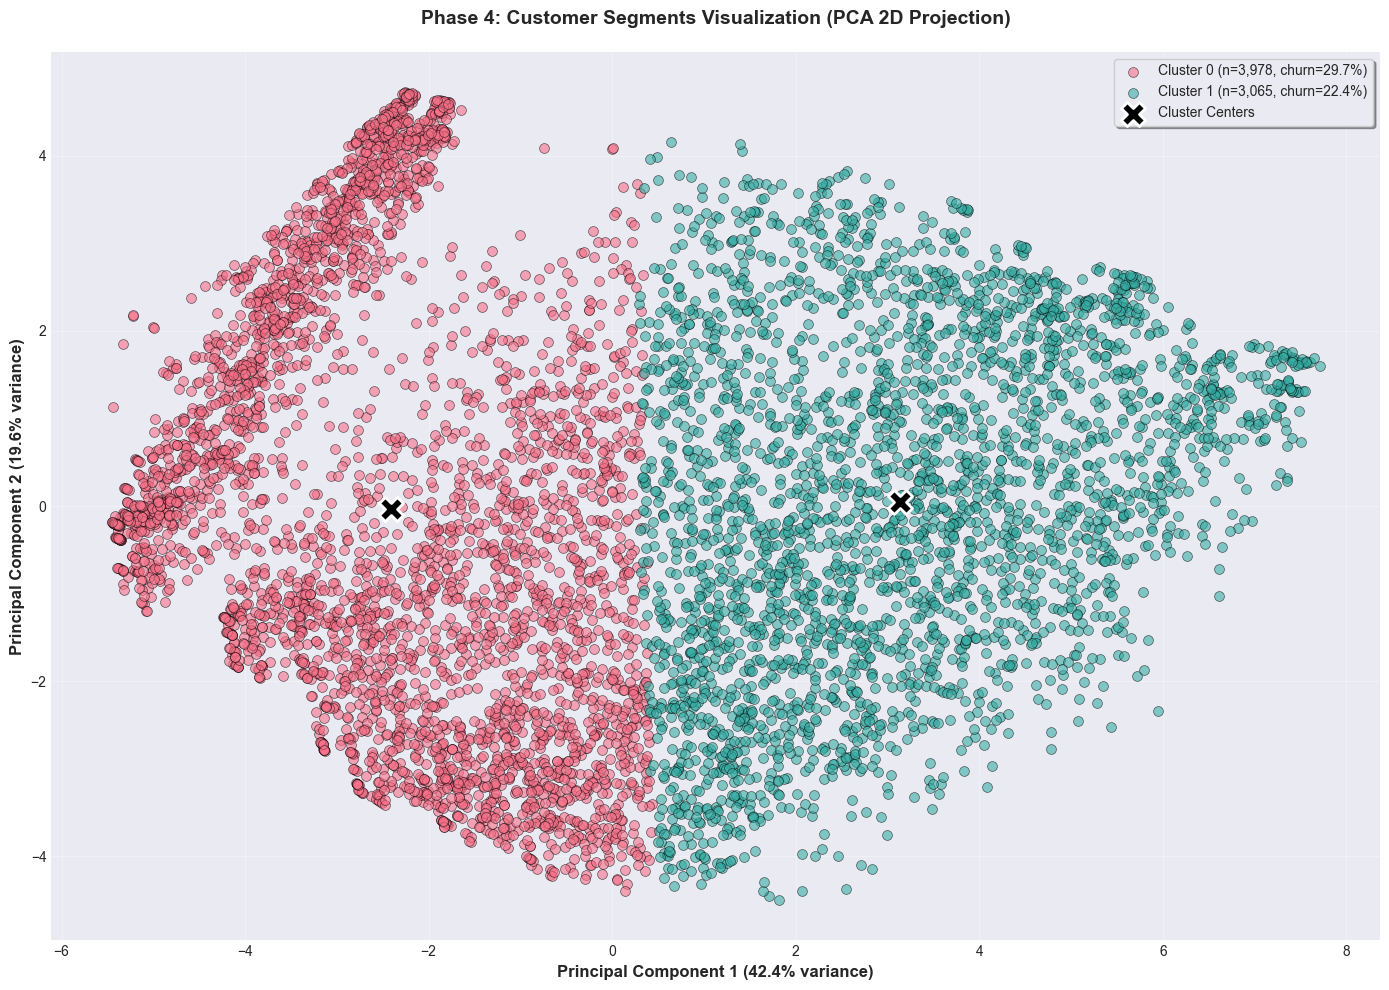


✅ Visualization saved: 24_segment_visualization_pca.png


In [14]:
# Create 2D scatter plot
fig, ax = plt.subplots(figsize=(14, 10))

# Define colors for clusters
colors_palette = sns.color_palette('husl', optimal_k)

# Plot each cluster
for cluster_id in range(optimal_k):
    cluster_mask = cluster_labels == cluster_id
    cluster_size = cluster_mask.sum()
    churn_rate = y_all[cluster_mask].mean() * 100
    
    ax.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1],
               c=[colors_palette[cluster_id]], 
               label=f'Cluster {cluster_id} (n={cluster_size:,}, churn={churn_rate:.1f}%)',
               alpha=0.6, s=50, edgecolors='black', linewidth=0.5)

# Plot cluster centers
centers_pca = pca.transform(kmeans_final.cluster_centers_)
ax.scatter(centers_pca[:, 0], centers_pca[:, 1],
           c='black', marker='X', s=300, edgecolors='white', linewidth=2,
           label='Cluster Centers', zorder=10)

ax.set_xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)', 
              fontsize=12, fontweight='bold')
ax.set_ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)', 
              fontsize=12, fontweight='bold')
ax.set_title('Phase 4: Customer Segments Visualization (PCA 2D Projection)', 
             fontsize=14, fontweight='bold', pad=20)
ax.legend(loc='best', frameon=True, shadow=True, fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(viz_path / '24_segment_visualization_pca.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✅ Visualization saved: 24_segment_visualization_pca.png")

## 9. Business Insights & Segment Naming

Assign meaningful names to segments based on their characteristics.

In [15]:
print("💡 BUSINESS INSIGHTS & SEGMENT NAMING")
print("="*80)

# Suggest names based on characteristics (you can customize these)
segment_names = {}

for cluster_id in range(optimal_k):
    cluster_data = X_all_clustered[X_all_clustered['cluster_label'] == cluster_id]
    churn_rate = cluster_data['Churn'].mean() * 100
    avg_tenure = cluster_data['tenure'].mean() if 'tenure' in cluster_data.columns else 0
    avg_charges = cluster_data['MonthlyCharges'].mean() if 'MonthlyCharges' in cluster_data.columns else 0
    
    # Auto-naming logic (customize as needed)
    if churn_rate > 40 and avg_tenure < 20:
        name = "Flight Risk (High Churn, New Customers)"
    elif churn_rate < 15 and avg_tenure > 40:
        name = "Loyal Champions (Low Churn, Long Tenure)"
    elif avg_charges > 80:
        name = "Premium Customers (High Spenders)"
    elif avg_charges < 40:
        name = "Budget Conscious (Low Spenders)"
    elif churn_rate > 30:
        name = "At Risk (Moderate-High Churn)"
    else:
        name = f"Standard Segment {cluster_id}"
    
    segment_names[cluster_id] = name
    
    print(f"\nCluster {cluster_id}: {name}")
    print(f"   • Size: {len(cluster_data):,} ({len(cluster_data)/len(X_all_clustered)*100:.1f}%)")
    print(f"   • Churn Rate: {churn_rate:.1f}%")
    print(f"   • Avg Tenure: {avg_tenure:.1f} months")
    print(f"   • Avg Monthly Charges: ${avg_charges:.2f}")
    
    # Retention strategy
    if churn_rate > 40:
        print(f"   • 🚨 Strategy: Urgent intervention - incentives, onboarding support")
    elif churn_rate > 25:
        print(f"   • ⚠️  Strategy: Proactive outreach, service upgrades, loyalty rewards")
    else:
        print(f"   • ✅ Strategy: Maintain satisfaction, upsell opportunities")

print("\n" + "="*80)

💡 BUSINESS INSIGHTS & SEGMENT NAMING

Cluster 0: Budget Conscious (Low Spenders)
   • Size: 3,978 (56.5%)
   • Churn Rate: 29.7%
   • Avg Tenure: -0.5 months
   • Avg Monthly Charges: $-0.62
   • ⚠️  Strategy: Proactive outreach, service upgrades, loyalty rewards

Cluster 1: Budget Conscious (Low Spenders)
   • Size: 3,065 (43.5%)
   • Churn Rate: 22.4%
   • Avg Tenure: 0.7 months
   • Avg Monthly Charges: $0.80
   • ✅ Strategy: Maintain satisfaction, upsell opportunities



## 10. Add Cluster Labels to Datasets

Split back to train/test with cluster labels added.

In [16]:
print("💾 ADDING CLUSTER LABELS TO DATASETS")
print("="*80)

# Split cluster labels back to train/test
cluster_labels_train = cluster_labels[:train_size]
cluster_labels_test = cluster_labels[train_size:]

# Add cluster labels as new feature
X_train_with_segments = X_train.copy()
X_train_with_segments['cluster_label'] = cluster_labels_train

X_test_with_segments = X_test.copy()
X_test_with_segments['cluster_label'] = cluster_labels_test

print(f"\n✅ Cluster labels added!")
print(f"   • X_train_with_segments: {X_train_with_segments.shape} (was {X_train.shape})")
print(f"   • X_test_with_segments: {X_test_with_segments.shape} (was {X_test.shape})")
print(f"   • New feature: 'cluster_label' (values: 0 to {optimal_k-1})")

# Verify cluster distribution in train/test
print(f"\n📊 Cluster distribution in train set:")
train_dist = X_train_with_segments['cluster_label'].value_counts().sort_index()
for cluster_id, count in train_dist.items():
    print(f"   Cluster {cluster_id}: {count:,} ({count/len(X_train_with_segments)*100:.1f}%)")

print(f"\n📊 Cluster distribution in test set:")
test_dist = X_test_with_segments['cluster_label'].value_counts().sort_index()
for cluster_id, count in test_dist.items():
    print(f"   Cluster {cluster_id}: {count:,} ({count/len(X_test_with_segments)*100:.1f}%)")

💾 ADDING CLUSTER LABELS TO DATASETS

✅ Cluster labels added!
   • X_train_with_segments: (5634, 66) (was (5634, 65))
   • X_test_with_segments: (1409, 66) (was (1409, 65))
   • New feature: 'cluster_label' (values: 0 to 1)

📊 Cluster distribution in train set:
   Cluster 0: 3,149 (55.9%)
   Cluster 1: 2,485 (44.1%)

📊 Cluster distribution in test set:
   Cluster 0: 829 (58.8%)
   Cluster 1: 580 (41.2%)


## 11. Save Enhanced Datasets

Save datasets with cluster labels for Phase 5 modeling.

In [17]:
print("💾 SAVING ENHANCED DATASETS WITH CLUSTER LABELS")
print("="*80)

# Save train/test with cluster labels
X_train_with_segments.to_csv(processed_path / 'X_train_with_segments.csv', index=False)
X_test_with_segments.to_csv(processed_path / 'X_test_with_segments.csv', index=False)

# Save segment profiles
segments_df['Segment_Name'] = segments_df['Cluster'].map(segment_names)
segments_df.to_csv(processed_path / 'phase4_segment_profiles.csv', index=False)

print(f"\n✅ Datasets saved:")
print(f"   • {processed_path / 'X_train_with_segments.csv'} ({X_train_with_segments.shape[0]:,} × {X_train_with_segments.shape[1]})")
print(f"   • {processed_path / 'X_test_with_segments.csv'} ({X_test_with_segments.shape[0]:,} × {X_test_with_segments.shape[1]})")
print(f"   • {processed_path / 'phase4_segment_profiles.csv'}")

print(f"\n💡 These datasets include the new 'cluster_label' feature for Phase 5 modeling!")

💾 SAVING ENHANCED DATASETS WITH CLUSTER LABELS

✅ Datasets saved:
   • /Users/mihiniboteju/churn-prediction-project/data/processed/X_train_with_segments.csv (5,634 × 66)
   • /Users/mihiniboteju/churn-prediction-project/data/processed/X_test_with_segments.csv (1,409 × 66)
   • /Users/mihiniboteju/churn-prediction-project/data/processed/phase4_segment_profiles.csv

💡 These datasets include the new 'cluster_label' feature for Phase 5 modeling!
